# Minflux data extraction

Load files to analyse and export the data using MfxData class
Perform an initial data inspection of reference beads, number of tracks etc. 


In [18]:
# Some imports
import sys
import os, glob
from mfx.mfxdata import MfxData 
import re
import math

ModuleNotFoundError: No module named 'mfxcolnames'

In [2]:
# Set names
# Reading from network drive Zarr is still rather slow. Do not know why. 
# Write/read to a 'local' Harddrive is 10x faster. The whole handling of a file takes 2 min, instead of 10-30 sec

def gen_directories( maindir, subdir, keys):
    outdir = {}
    for key in keys:
        outdir[key] = os.path.join(maindir, subdir, key)
    return outdir

def gen_msrfiles(dir_dict):
    msr_files = {}
    for key in dir_dict:
        msr_files[key] = glob.glob(os.path.join(dir_dict[key], '*.msr'))
    return msr_files


OUTDIR_LOC = 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis' # Main directory to store zarr files
OUTDIR_REM =  'Z:/siva_minflux/analysis'  # Main directory to store results 
INDIR  = 'Z:/siva_minflux/data'       # main directory of msr file

# Multiple washes with different imager strand
keys = ['Syp_ATG9', 'ZnT3_Syp', 'Syp_Picc']
indir_mwash = gen_directories(INDIR, 'Multiwash', keys)
outdir_mwash = gen_directories(OUTDIR_REM, 'Multiwash', keys)
zarrdir_mwash = gen_directories(OUTDIR_LOC, 'Multiwash', keys) 
msr_mwash = gen_msrfiles(indir_mwash)

# Wash with a single imager strand
keys = ['Syp', 'ATG9', 'VGLUT1']
indir_swash =  gen_directories(INDIR, 'Single wash', keys)
outdir_swash =  gen_directories(OUTDIR_REM, 'Single wash', keys)
zarrdir_swash =  gen_directories(OUTDIR_LOC, 'Single wash', keys)
msr_swash = gen_msrfiles(indir_swash)


# Consitency controls. Wash with a single imager strand but multiple times. 
keys = ['VGLUT1_VGLUT1']
indir_cwash =  gen_directories(INDIR, 'Multiwash', keys)
outdir_cwash = gen_directories(OUTDIR_REM, 'Multiwash', keys)
zarrdir_cwash = gen_directories(OUTDIR_LOC, 'Multiwash', keys) 
msr_cwash = gen_msrfiles(indir_cwash)


In [3]:
# Realign data funcion
def align_data(msr_files, outdir, zarr_dir, invalid_msr, exclude_beads, time_diff_ref, wash_to_use = None):
    for wash_key in msr_files:
        if wash_to_use is not None and wash_key not in wash_to_use:
            continue
        for file_path in msr_files[wash_key]:
            
            file_name = os.path.basename(file_path)
            if file_name in invalid_msr:
                continue
            mfx = MfxData(file_path, outdir_main=outdir[wash_key], 
                          zarr_dir_main=zarr_dir[wash_key])
            if file_name in time_diff_ref:
                mfx.MAX_TDIFF_REF = time_diff_ref[file_name]
            else:
                mfx.MAX_TDIFF_REF = 10
            mfx.zarr_import()
            mfx.set_valid_ref()
            print('\n'+ mfx.msrfile_path)
            print(mfx.valid_ref_beads)
            if file_name in exclude_beads:
                mfx.valid_ref_beads = [x for x in mfx.valid_ref_beads if x not in exclude_beads[file_name]]
            print(mfx.valid_ref_beads)
            regis = mfx.get_ref_transform()
            mfx.show_ref_transform(translate=regis[mfx.TRANS], rotate=None, save=True, show=True)
            out_data_dict = mfx.align_to_ref()
            mfx.export_numpy(out_data_dict)
            mfx.export_ref_mat() 

def preview_data(msr_files, outdir, zarr_dir, idfile, wash_key, time_diff_ref = 10, exclude_beads = None):
    mfx = MfxData(msr_files[wash_key][idfile], outdir_main=outdir[wash_key], 
                          zarr_dir_main=zarr_dir[wash_key])
    print(mfx.msrfile_path)
    mfx.MAX_TDIFF_REF = time_diff_ref
    mfx.zarr_import()
    print(mfx.zarrdir)
    mfx.set_valid_ref()
    print(mfx.valid_ref_beads)
    if len(mfx.valid_ref_beads)==0:
        printt('No valid reference beads ')
        return
    if exclude_beads is not None:
        mfx.valid_ref_beads = [x for x in mfx.valid_ref_beads if x not in exclude_beads]
    regis = mfx.get_ref_transform()
    mfx.show_ref_transform(translate=regis[mfx.TRANS], rotate=None, save=False, show=True)


Z:/siva_minflux/data\Multiwash\Syp_Picc\220804_Syp_Picc_ROI01.msr
{'220804-Syp_P1': 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis\\Multiwash\\Syp_Picc\\220804_Syp_Picc_ROI01\\220804-Syp_P1', '220804-Picc_P2': 'C:/Users/apoliti/Desktop/mflux_zarr_tmp_storage/analysis\\Multiwash\\Syp_Picc\\220804_Syp_Picc_ROI01\\220804-Picc_P2'}
['R2', 'R20', 'R34']


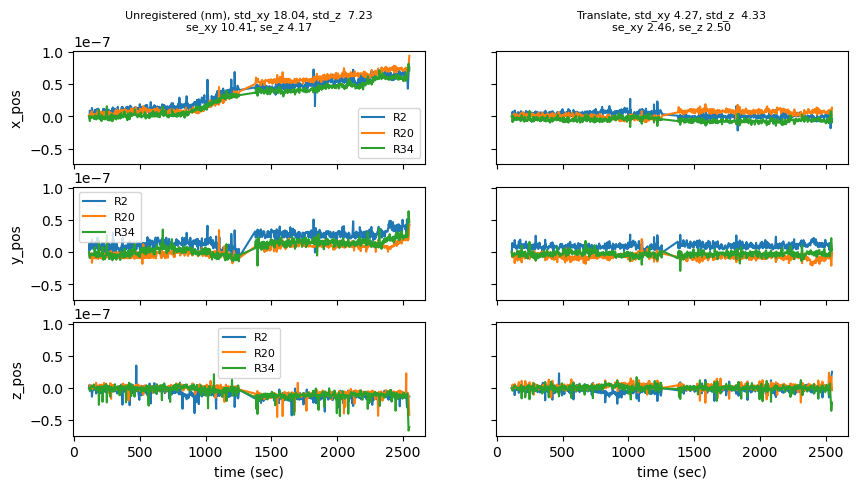

In [84]:
# Preview data mwash
preview_data(msr_files=msr_mwash, outdir=outdir_mwash, zarr_dir=zarrdir_mwash,  wash_key='Syp_Picc',
             idfile=0, time_diff_ref=2500)

In [85]:
# Valid msr files, for instance because lacking of common reference. This can be fixed at a later time point 
invalid_mwash = {'220510_Syp_ATG9_ROI02.msr'}
exclude_beads_mwash = {'220510_Syp_ATG9_ROI03.msr': ['R4'], '220601_Syp_ATG9_ROI03.msr': ['R10'], 
                       '220825_Syp_ATG9_ROI01.msr': ['R13']}
time_diff_mwash = {'220309_ZnT3_Syp_ROI01.msr': 1500, '220309_ZnT3_Syp_ROI03.msr': 1200, 
                  '220804_Syp_Picc_ROI01.msr': 2500}
# Syp_ATG9
# 220510_Syp_ATG9_ROI01.msr: 6 beads, good
# 220510_Syp_ATG9_ROI02.msr: No common beads, needs a matching
# 220510_Syp_ATG9_ROI03.msr: Exclude R4
# 220601_Syp_ATG9_ROI01.msr: 3 beads, ok
# 220601_Syp_ATG9_ROI02.msr: 4 beads, good
# 220601_Syp_ATG9_ROI03.msr: 4 beads, ok,  exclude R10
# 220601_Syp_ATG9_ROI04.msr: 4 beads, good
# 220601_Syp_ATG9_ROI05.msr: 4 beads, ok
# 220601_Syp_ATG9_ROI06.msr: 4 beads, good
# 220601_Syp_ATG9_ROI07.msr: 3 beads, ok
# 220614_Syp_ATG9_ROI01.msr: 3 beads, ok
# 220825_Syp_ATG9_ROI01.msr: 5 beads, poor, strange fluctuations. Exclude R13. Failed to align ??. Do not use

# ZnT3_Syp
# 220309_ZnT3_Syp_ROI01.msr: 3 beads, ok
# 220309_ZnT3_Syp_ROI02.msr: 3 beads, ok 
# 220309_ZnT3_Syp_ROI03.msr: 2 beads!!, poor



Z:/siva_minflux/data\Multiwash\Syp_Picc\220804_Syp_Picc_ROI01.msr
['R2', 'R20', 'R34']
['R2', 'R20', 'R34']


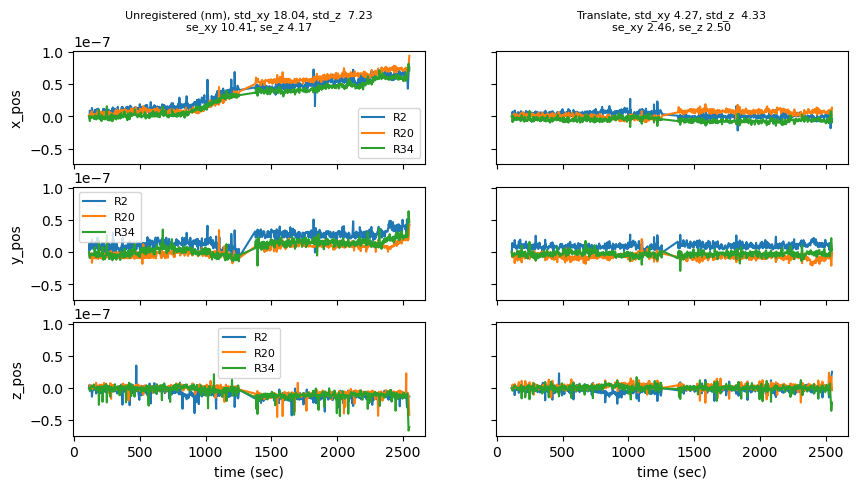

Valid tracks 220804-Syp_P1 1240/116570
Localizations in invalid tracks 220804-Syp_P1 10/123305
Valid tracks 220804-Picc_P2 6651/130199
Localizations in invalid tracks 220804-Picc_P2 10/161873


In [86]:
# Realign data 
align_data(msr_files=msr_mwash, outdir=outdir_mwash, zarr_dir=zarrdir_mwash, 
           invalid_msr=invalid_mwash, exclude_beads=exclude_beads_mwash, 
           time_diff_ref=time_diff_mwash, wash_to_use='Syp_Picc')
        

In [ ]:
# Preview data single
preview_data(msr_files=msr_swash, outdir=outdir_swash, zarr_dir=zarrdir_swash, 
             wash_key='VGLUT1', idfile=1, time_diff_ref=10, exclude_beads = ['R18', 'R11'  ])


In [75]:
# Valid msr files, for instance because lacking of common reference. This can be fixed at a later time point 
invalid_swash = {}
exclude_beads_swash = {'220921_VGLUT1_ROI02.msr': ['R18', 'R11']}
# Achieve 3 or more beads, or leave 2 if not enough time points
time_diff_swash = {'220825_Syp_ROI2.msr': 300, '220825_Syp_ROI3.msr': 1100, 
                   '220825_Syp_ROI4.msr': 1200, '220825_Syp_ROI5.msr': 10, 
                    '220825_Syp_ROI6.msr': 10, '220825_ATG9_ROI3.msr': 400 }
# Syp
# 220825_Syp_ROI2.msr: 3 beads, ok
# 220825_Syp_ROI3.msr: 3 beads, ok
# 220825_Syp_ROI4.msr: 3 beads, ok; 1200 sec
# 220825_Syp_ROI5.msr: 5 beads, good
# 220825_Syp_ROI6.msr: 2 beads!, poor. Otherwise only 10 min

# ATG9
# 220825_ATG9_ROI2.msr: 4 beads, good
# 220825_ATG9_ROI3.msr: 3 beads, ok
# 220825_ATG9_ROI4.msr: 3 beads, ok
# 220825_ATG9_ROI5.msr: 2 beads, poor
# 220825_ATG9_ROI6.msr: 3 beads, ok

# VGLUT1
# 220621_VGLUT1_ROI01.msr: 2 beads only


Z:/siva_minflux/data\Single wash\VGLUT1\220621_VGLUT1_ROI01.msr
['R15', 'R22']
['R15', 'R22']


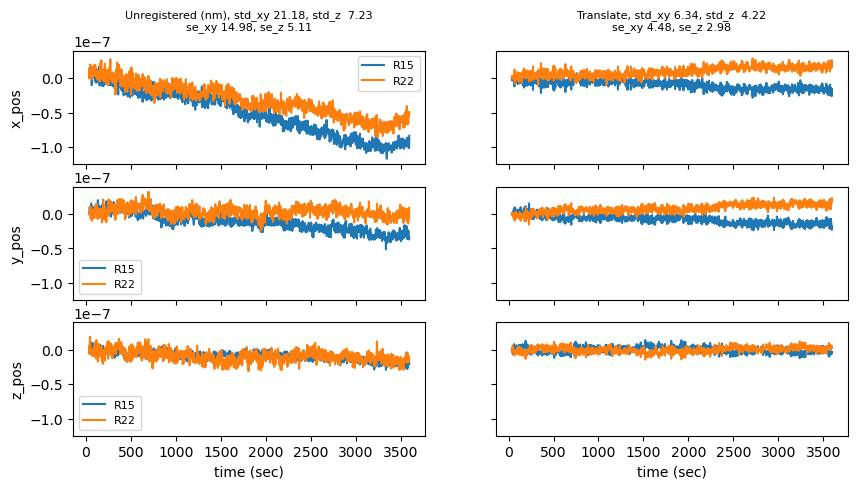

Valid tracks 220621-VGLUT1_P1 2746/105336
Localizations in invalid tracks 220621-VGLUT1_P1 17/124265

Z:/siva_minflux/data\Single wash\VGLUT1\220921_VGLUT1_ROI02.msr
['R11', 'R13', 'R14', 'R18', 'R22', 'R4', 'R6', 'R7']
['R13', 'R14', 'R22', 'R4', 'R6', 'R7']


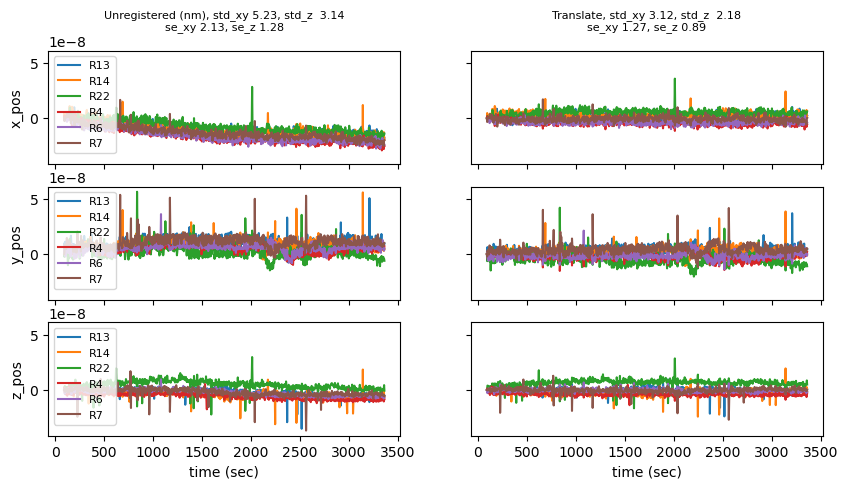

Valid tracks 220921-VGLUT1_P1 6645/90280
Localizations in invalid tracks 220921-VGLUT1_P1 44/122705


In [76]:

align_data(msr_files=msr_swash, outdir=outdir_swash, zarr_dir=zarrdir_swash, 
           invalid_msr=invalid_swash, exclude_beads=exclude_beads_swash, time_diff_ref=time_diff_swash, wash_to_use=['VGLUT1'])
        

In [ ]:
# Preview data cwash
preview_data(msr_files=msr_cwash, outdir=outdir_cwash, zarr_dir=zarrdir_cwash,  wash_key='VGLUT1_VGLUT1',
             idfile=0, time_diff_ref=800)

In [7]:
# Valid msr files, for instance because lacking of common reference. This can be fixed at a later time point 
invalid_cwash = {}
exclude_beads_cwash = {}
# Achieve 3 or more beads, or leave 2 if not enough time points
time_diff_cwash = {'220804_VGLUT1_ROI01_First.msr': 800, '220804_VGLUT1_ROI01_Second.msr': 800}
# VGLUT1
# 220804_VGLUT1_ROI01_First.msr: 2 beads only. Only 1 that cross-matches between washes = 'R17'
# 220804_VGLUT1_ROI01_First.msr: 2 beads only. Only 1 that cross-matches between washes = 'R17'
# 2208011_VGLUT1_ROI01_First.msr: 5 beads. May be  [['R1', 'R6'], ['R22', 'R15'], ['R3', 'R7'], ['R8', 'R9']]
# 2208011_VGLUT1_ROI01_Second.msr: 5 beads match with 150 nm distance!



In [8]:
# Hack because of not merged files
indir_cwash = INDIR + '/Multiwash/VGLUT1_VGLUT1/'
outdir_cwash = OUTDIR_REM +  '/Multiwash/VGLUT1_VGLUT1/'
zarrdir_cwash =  OUTDIR_LOC +  '/Multiwash/VGLUT1_VGLUT1/'

msr_cwash = ['Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220804_VGLUT1_ROI01_First.msr', 
             'Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220811_VGLUT1_ROI01_First.msr']

zarr_dir = {'220804_VGLUT1_ROI01_First.msr': {'220804_VGLUT1_P1': zarrdir_cwash + '/220804_VGLUT1_ROI01/220804_VGLUT1_P1',
             '220804_VGLUT1_P2': zarrdir_cwash + '/220804_VGLUT1_ROI01/220804_VGLUT1_P2'},
            '220811_VGLUT1_ROI01_First.msr': {'220811_VGLUT1_P1': zarrdir_cwash + '/220811_VGLUT1_ROI01/220811_VGLUT1_P1',
             '220811_VGLUT1_P2': zarrdir_cwash+ '/220811_VGLUT1_ROI01/220811_VGLUT1_P2'} }



Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220804_VGLUT1_ROI01_First.msr
['R17']
['R17']


\\s1602-fs01\DATA16020\Antonio_Politi\Code\minflux-analysis\python\mfx\mfx\mfxdata.py:217: UserWarning: Less than 3 reference beads, rotation registration is not computed
  warnings.warn("Less than 3 reference beads, rotation registration is not computed", category=UserWarning)


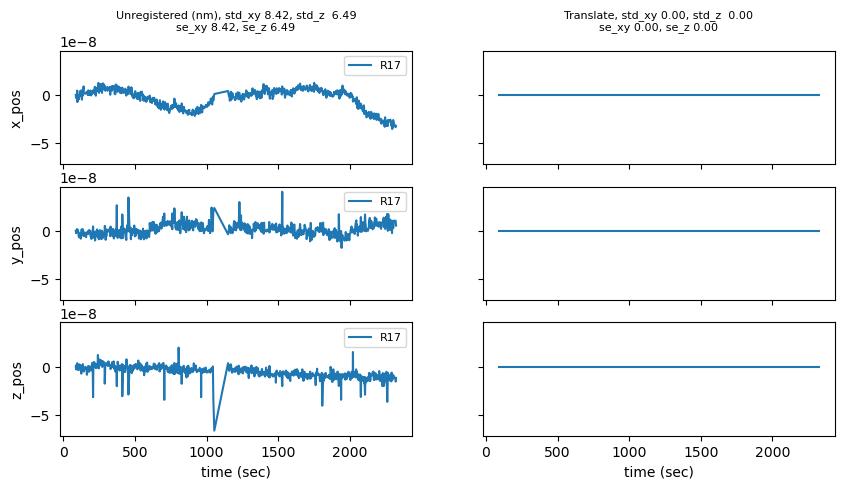

Valid tracks 220804_VGLUT1_P1 555/54066
Localizations in invalid tracks 220804_VGLUT1_P1 2/56596
Valid tracks 220804_VGLUT1_P2 464/62245
Localizations in invalid tracks 220804_VGLUT1_P2 1/64386

Z:/siva_minflux/data/Multiwash/VGLUT1_VGLUT1/220811_VGLUT1_ROI01_First.msr
['R1', 'R22', 'R3', 'R8']
['R1', 'R22', 'R3', 'R8']


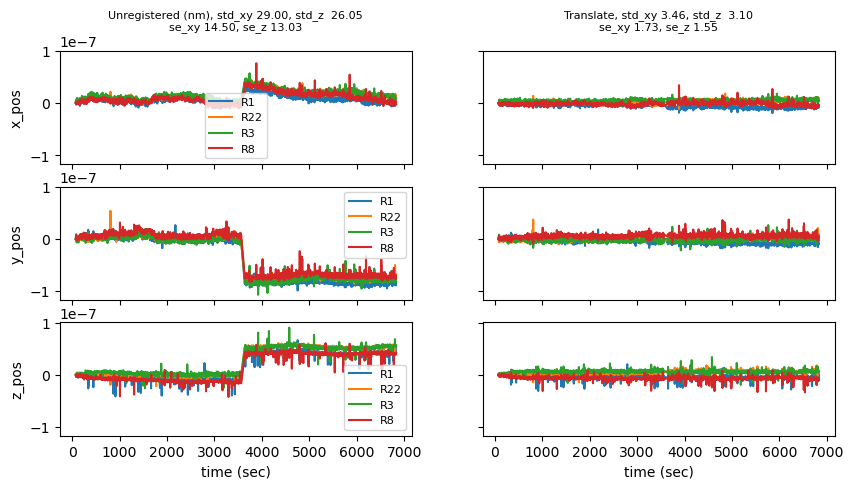

Valid tracks 220811_VGLUT1_P1 2800/100724
Localizations in invalid tracks 220811_VGLUT1_P1 23/115104
Valid tracks 220811_VGLUT1_P2 1989/95253
Localizations in invalid tracks 220811_VGLUT1_P2 12/104441


In [9]:
for file_path in msr_cwash:
    file_name = os.path.basename(file_path)
    if file_name in invalid_cwash:
        continue
    mfx = MfxData(file_path, outdir_main=outdir_cwash, 
                  zarr_dir_main=zarrdir_cwash)
    if file_name in time_diff_cwash:
        mfx.MAX_TDIFF_REF = time_diff_cwash[file_name]
    else:
        mfx.MAX_TDIFF_REF = 10
    mfx.zarrdir = zarr_dir[file_name]
    mfx.zarr_import()
    mfx.set_valid_ref()
    print('\n'+ mfx.msrfile_path)
    print(mfx.valid_ref_beads)
    if file_name in exclude_beads_cwash:
        mfx.valid_ref_beads = [x for x in mfx.valid_ref_beads if x not in exclude_beads_cwash[file_name]]
    print(mfx.valid_ref_beads)
    regis = mfx.get_ref_transform()
    mfx.show_ref_transform(translate=regis[mfx.TRANS], rotate=None, save=True, show=True)
    out_data_dict = mfx.align_to_ref()
    mfx.export_numpy(out_data_dict)
    mfx.export_ref_mat() 

In [28]:
tmp = mfx.mfx_all['220811_VGLUT1_P1']['itr']['eco'][mfx.mfx_all['220811_VGLUT1_P1']['vld']]


In [32]:
tmp[0:10]
tids = mfx.mfx_all['220811_VGLUT1_P1']['tid'][mfx.mfx_all['220811_VGLUT1_P1']['vld']]

In [38]:
tids[1:7]
tmp[1:7]

array([[176, 460, 135,  54,  71,  68, 120,  50, 114,  60],
       [  0,   0,   0,   0,   0,   0,  78,  92, 217, 132],
       [  0,   0,   0,   0,   0,   0,  80,  54, 126,  98],
       [  0,   0,   0,   0,   0,   0, 124, 160, 160, 102],
       [  0,   0,   0,   0,   0,   0,  82,  68, 187, 182],
       [  0,   0,   0,   0,   0,   0,  88,  48, 135, 166]])